In [1]:
# Crafted by Collin Miller

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import bisect
import cv2
import h5py
import keras
from models import ChopinNet
from models import BachNet

import networkx as nx
import numpy as np
import os
import re
import sys
import time
import threading


from heapq import heappop as pop
from heapq import heappush as push
from utils import graph_utils
from utils import display_utils
from utils import prediction_utils
from utils import preprocessing_utils
from utils import relative_assignments

Using TensorFlow backend.


In [5]:
from skimage import io

In [6]:
from utils.prediction_utils import input_generator

In [7]:
train_path = "data/train"
test_path = "data/test"

input_path = "input"
output_path = "output"

gt_tag = "gt"


receptive_field_shape = (12, 12)
n_epochs = 32

In [8]:
bach = BachNet.BachNet()
bach.build(receptive_field_shape, 1)
bach.load_model('models/saved_models/Bach/model.h5')

batch = dict()
input_gen = prediction_utils.input_generator(bach, train_path, input_path, gt_tag)

while True:
    try:
        f_name, img, bps, I_a, gt, gt_cuts, seeds = next(input_gen)
        graph = graph_utils.prims_initialize(img)
        batch[f_name] = img, bps, I_a, gt, gt_cuts, seeds, graph
    except StopIteration:
        break

Loading image:  740_1450_gt
Loading image:  740_1450
Loading image:  740_1450


In [9]:
chopin = ChopinNet.Chopin()
chopin.build(receptive_field_shape, learning_rate=1e-5)
chopin.initialize_session()
#chopin.load_model("models/saved_models/Chopin/chopin.data-00000-of-00001")

In [10]:
global_loss_timeline = []
loss_timelines = dict()
loss_file = open("data/train/chopin/global_loss.txt", 'w')
loss_file.write("f_name\tepoch\tloss\n")

for f_name, (img, bps, I_a, gt, gt_cuts, seeds, graph) in batch.iteritems():
    print("Training on", f_name)
    foldername = os.path.join(train_path, "chopin", f_name)
    for epoch in range(n_epochs):
        start = time.time()

Training on 740_1450


740_1450


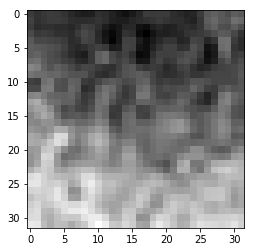

In [11]:
print(f_name)
plt.imshow(img, cmap='gray')

In [12]:
plt.imsave("test/gt_cuts.png", display_utils.view_boundaries(img, gt_cuts))

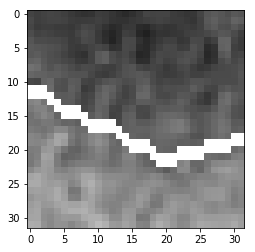

In [14]:
plt.imshow(display_utils.view_boundaries(img, gt_cuts))

Starting gradient segmentation...
Segmentation done: 5.614355s
Starting gradient segmentation...
Segmentation done: 0.037836s


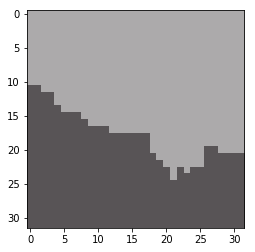

In [23]:
loss, segmentations, cuts = chopin.train_on_image(img, I_a, gt_cuts, seeds, graph)

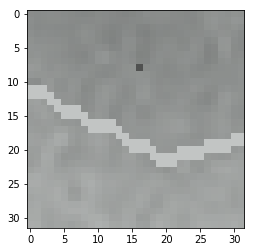

In [19]:
plt.imshow(display)

Starting gradient segmentation...
Segmentation done: 5.620846s
Starting gradient segmentation...
Segmentation done: 0.040839s
31.0926704407


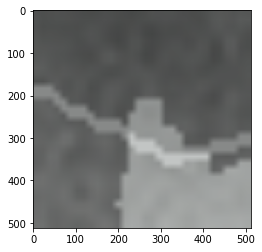

In [19]:
msf = chopin.predicted_msf(I_a, graph, seeds)
cuts = graph_utils.get_cut_edges(graph, msf)
constrained_msf = chopin.constrained_msf(I_a, graph, msf, seeds, gt_cuts)
shortest_paths, ground_truth_paths = graph_utils.get_paths(graph, msf, constrained_msf)

children = graph_utils.compute_root_error_edge_children(shortest_paths,
                                            ground_truth_paths, cuts,
                                            gt_cuts)

segmentations = display_utils.assignments(np.zeros_like(img), msf, seeds)
display = display_utils.transparent_mask(display_utils.view_boundaries(img, gt_cuts), segmentations, alpha=0.7)
display = cv2.resize(display, (512, 512)) 
assignments = nx.get_node_attributes(msf, 'seed')

weights = []
static_images = []
dynamic_images = []

for (u, v), weight in children.iteritems():
    static_images.append(graph.get_edge_data(u, v)['static_image'])
    dynamic_images.append(graph.get_edge_data(u, v)['dynamic_image'])
    weights.append(weight)
    altitude_val = graph.get_edge_data(u, v)['weight']

batches = zip(preprocessing_utils.create_batches(np.expand_dims(np.stack(weights), 1)),
              preprocessing_utils.create_batches(np.concatenate(static_images)),
              preprocessing_utils.create_batches(np.concatenate(dynamic_images)))

loss = 0
with chopin.sess.as_default():
    chopin.sess.run(chopin.zero_ops)

    for w, s, d in batches:
        feed_dict = {chopin.gradient_weights: w.transpose(),
                     chopin.static_input: s,
                     chopin.dynamic_input: d,
                     keras.backend.learning_phase(): 0}

        chopin.sess.run(
            chopin.accum_ops, feed_dict)
        loss += chopin.sess.run(chopin.loss, feed_dict)[0][0]

    chopin.sess.run(chopin.train_step)
print(loss)
plt.imshow(display)

In [33]:
chopin.save_model("models/saved_models/Chopin/chopin")